In [216]:
#importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn import preprocessing
from sklearn.ensemble import *
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [217]:
train=pd.read_csv('train_users_2.csv')
test=pd.read_csv('test_users.csv')


In [218]:
print('The training data contains', train.shape[0], 'columns and', train.shape[1], ' rows.   While the test data contains',  test.shape[0], 'columns and', test.shape[1], '.')

The training data contains 213451 columns and 16  rows.   While the test data contains 62096 columns and 15 .


In [219]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [220]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [221]:
for i in train.columns:
  if train[i].isna().sum() !=0:
    print('The columns "', i, '" has', train[i].isna().sum(), 'null values.' )

The columns " date_first_booking " has 124543 null values.
The columns " age " has 87990 null values.
The columns " first_affiliate_tracked " has 6065 null values.


In [222]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [223]:
train = train.drop(['date_first_booking'], axis = 1)
test= test.drop(['date_first_booking'], axis=1)


In [224]:
#let's drop these columns because according to the features importance they should not be in there
train = train.drop(['signup_app','first_browser','signup_flow'], axis = 1)
test = test.drop(['signup_app','first_browser','signup_flow'], axis = 1)


In [225]:
#Converting below columns as categories for plotting in graphs
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
 #   'first_browser',
    'first_device_type',
    'gender',
    'language',
 #   'signup_app',
    'signup_method',
  #  'signup_flow'
]

for categorical_feature in categorical_features:
    train[categorical_feature] = train[categorical_feature].astype('category')
    test[categorical_feature] = test[categorical_feature].astype('category')

In [226]:
train['date_account_created'] = pd.to_datetime(train['date_account_created'])

test['date_account_created'] = pd.to_datetime(test['date_account_created'])


In [227]:
# timestamp_first_active transformation
# Here as well we separate the timestamp first active into day mount and year
#train.timestamp_first_active = train.timestamp_first_active.apply(lambda x: x.timestamp())

tfa = np.vstack(train.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)

print(tfa)
train['tfa_year'] = tfa[:,0]
train['tfa_month'] = tfa[:,1]
train['tfa_day'] = tfa[:,2]


train['timestamp_first_active']=pd.to_datetime(train['timestamp_first_active'],format='%Y%m%d%H%M%S')
from datetime import datetime
k=[]
for i in train['timestamp_first_active']:
  k.append(i.strftime('%A'))

train['tfa_day']=k

#train = train.drop(['timestamp_first_active'], axis=1)



[[2009    3   19    4   32   55]
 [2009    5   23   17   48    9]
 [2009    6    9   23   12   47]
 ...
 [2014    6   30   23   57   54]
 [2014    6   30   23   58   22]
 [2014    6   30   23   58   24]]


**AGE**

In [228]:
train.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [229]:
(train.age > 100).value_counts()


False    211106
True       2345
Name: age, dtype: int64

In [230]:
(train.age < 18).value_counts()


False    213293
True        158
Name: age, dtype: int64

In [231]:
train[(train['age']<18) & (train['age']>=100)].age = np.nan
test[(train['age']<18) & (test['age']>=100)].age = np.nan


In [232]:
train.shape[0]-train.age.isna().sum()

125461

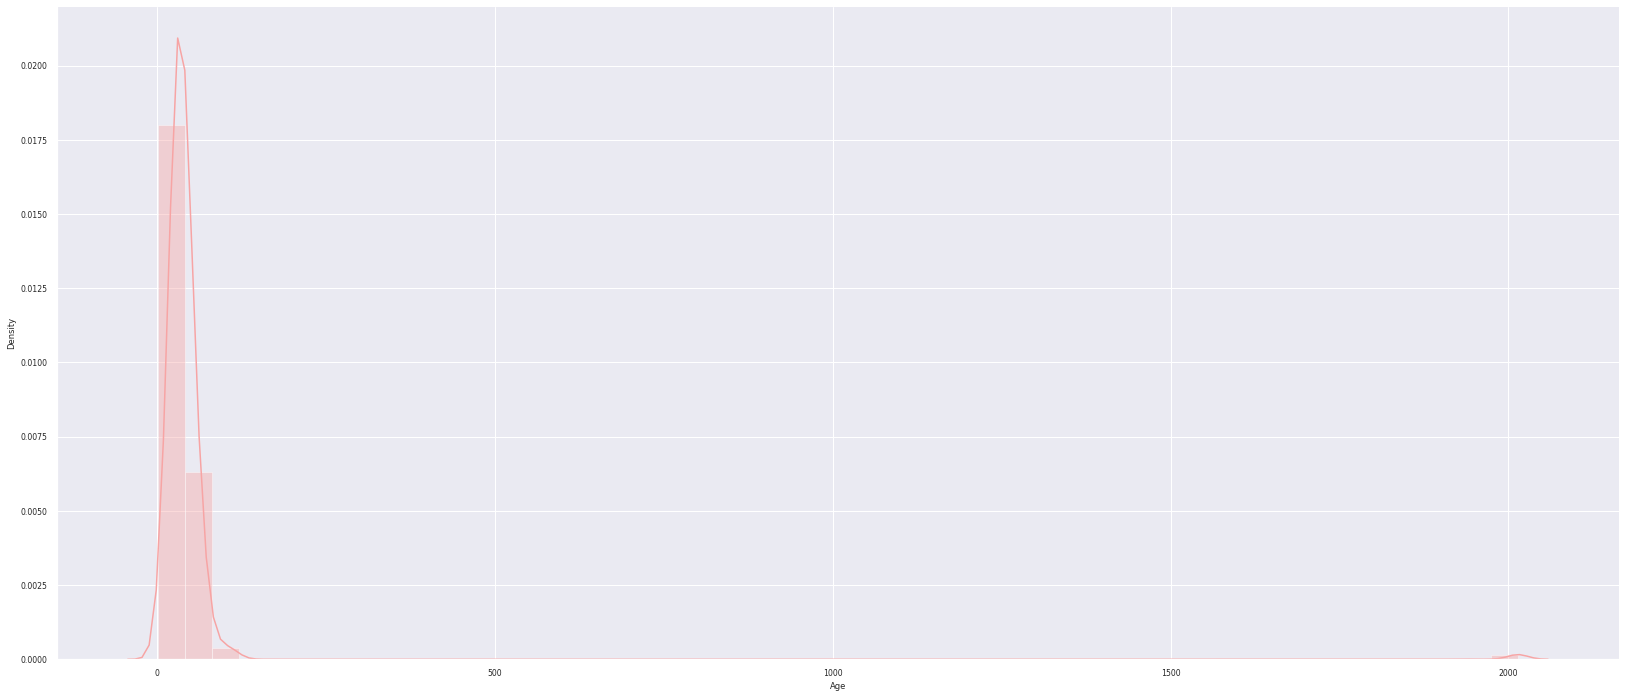

In [233]:
plt.figure(figsize=(28,12))


sns.distplot(train.age.dropna(), color='#F7A4A4')
plt.xlabel('Age')
sns.despine()

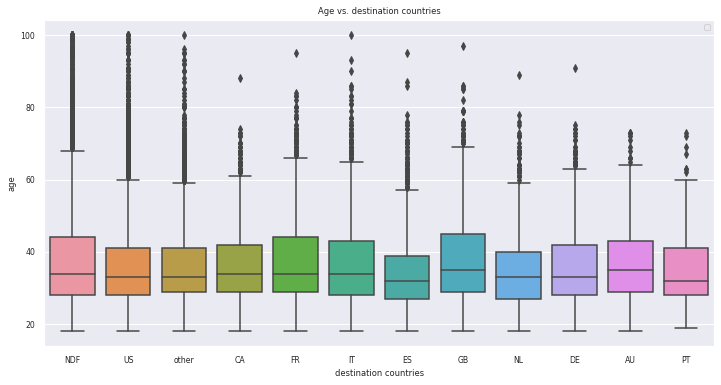

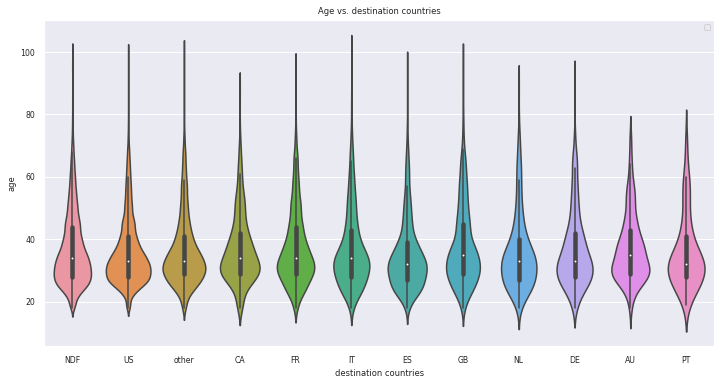

In [234]:
train.loc[(train.age > 100) | (train.age < 18), 'age'] = np.nan
plt.figure(figsize=(12,6))
sns.boxplot(x='country_destination',y='age', data=train.dropna())
plt.xlabel('destination countries')
plt.title('Age vs. destination countries')
plt.legend()
plt.show()

train.loc[(train.age > 105) | (train.age < 15), 'age'] = np.nan
plt.figure(figsize=(12,6))
sns.violinplot(x='country_destination',y='age', data=train.dropna())
plt.xlabel('destination countries')
plt.title('Age vs. destination countries')
plt.legend()
plt.show();

The common age to travel is between 20 and 40. Let's see if, older people 
travel in a different way. Let's pick an age, par hasard, to split into two groups. 40 for example

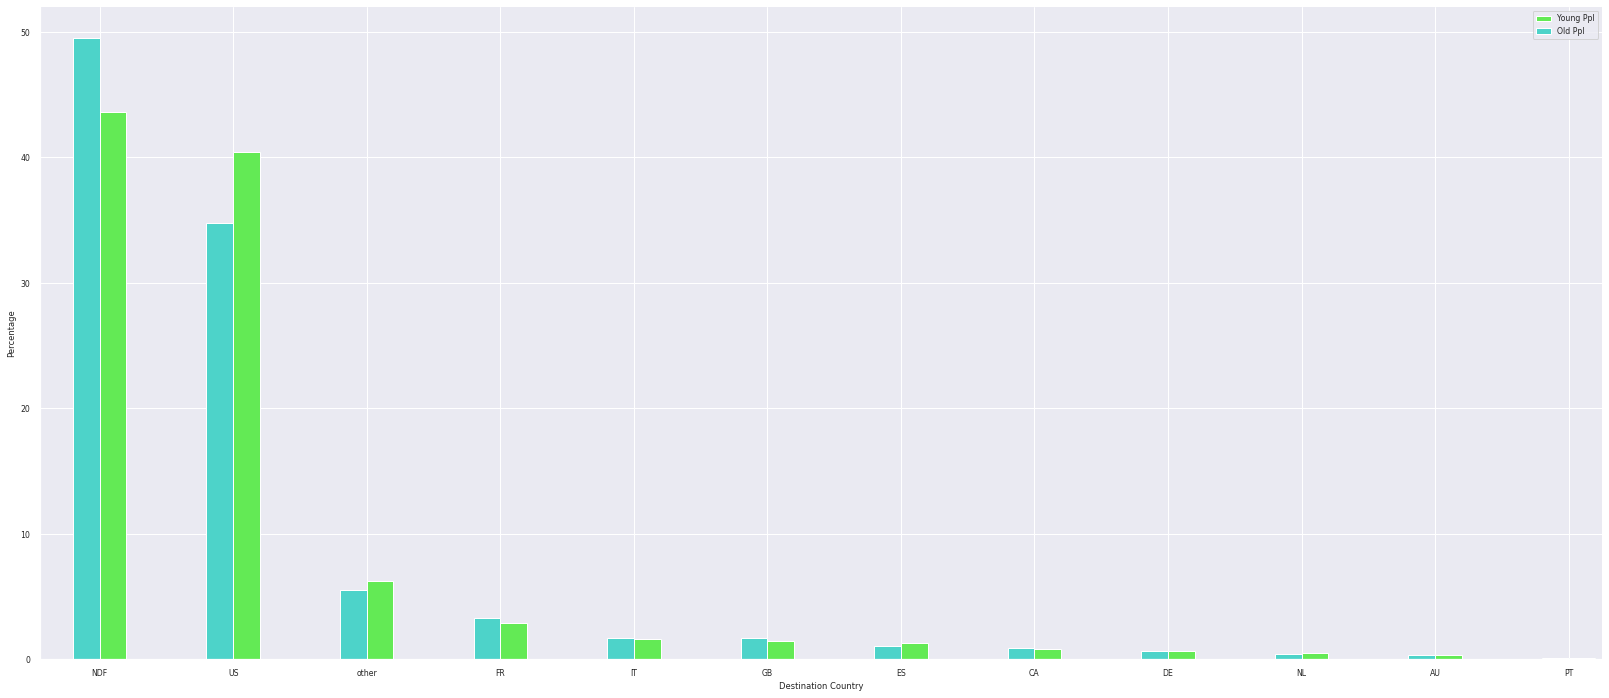

In [235]:
plt.figure(figsize=(28,12))

age = 40

younger = sum(train.loc[train['age'] < age, 'country_destination'].value_counts())
older = sum(train.loc[train['age'] > age, 'country_destination'].value_counts())

younger_destinations = train.loc[train['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = train.loc[train['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=0.2, color='#63EA55', position=0, label='Young Ppl', rot=0)
older_destinations.plot(kind='bar', width=0.2, color='#4DD3C9', position=1, label='Old Ppl', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()


We can see that the young people tend to stay in the US, and the older people choose to travel outside the country. 
The first thing we thought when reading the problem was the importance of the native lenguage when choosing the destination country. So let's see how manny users use english as main language:

In [236]:
print(((sum(train.language == 'en') / train.shape[0])*100), "people use English as main language")


96.65637546790599 people use English as main language


With the 96% of users using English as their language, it is understandable that a lot of people stay in the US. 

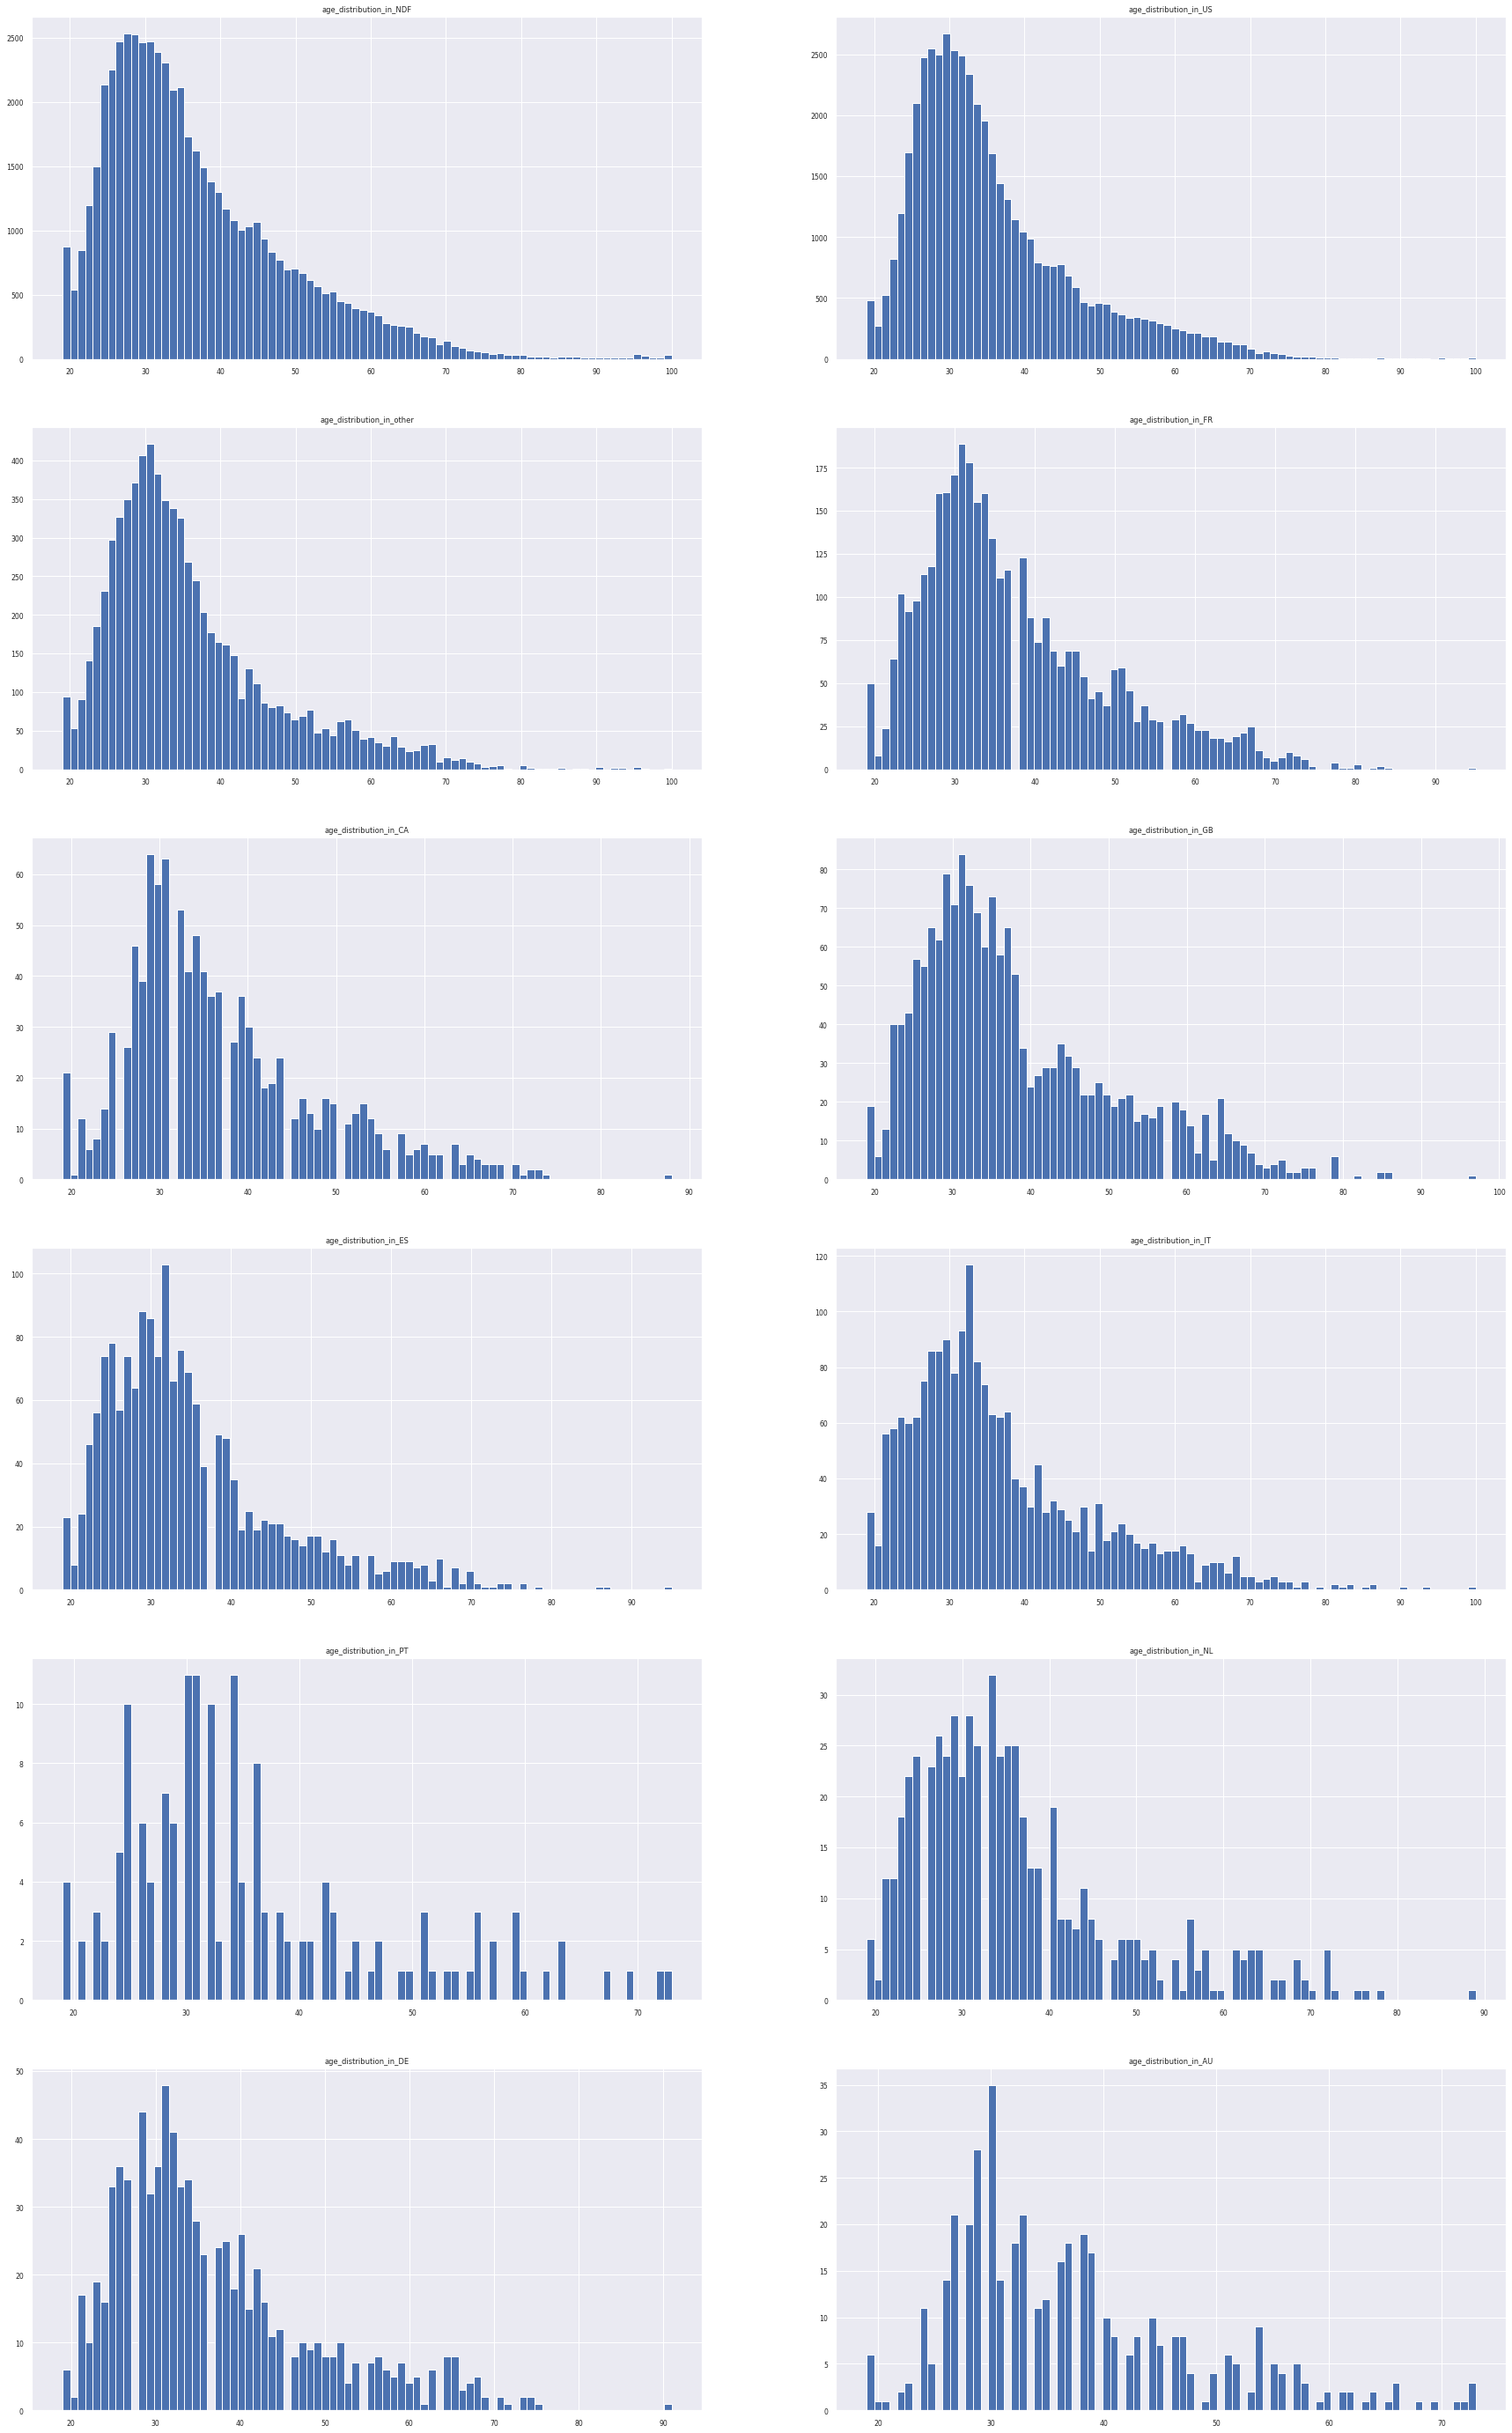

In [237]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(30, 50))
i=0
j=0

#for col_cnts_df_list in ls_of_column_counts_df_lists[0:2]:
for country in train['country_destination'].unique():
    axes[i, j].hist(train[(train['age']>18) & (train['age']<=100) & (train['country_destination']== country)]['age'], bins=80)
    axes[i, j].set_title('age_distribution_in_{}'.format(country))
    if(j<1):
        j+=1
    else:
        i+=1
        j=0
plt.xticks()
plt.show()


In [238]:
#let's fill the null values with the median 

train['age']= train['age'].fillna(train['age'].median())
test['age']= test['age'].fillna(train['age'].median())

**GENDER**

In [239]:
print('for train data: ', train.gender.value_counts())
print('-----------------------------')
print('for test data: ', test.gender.value_counts())


for train data:  -unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64
-----------------------------
for test data:  -unknown-    33792
FEMALE       14483
MALE         13769
OTHER           52
Name: gender, dtype: int64


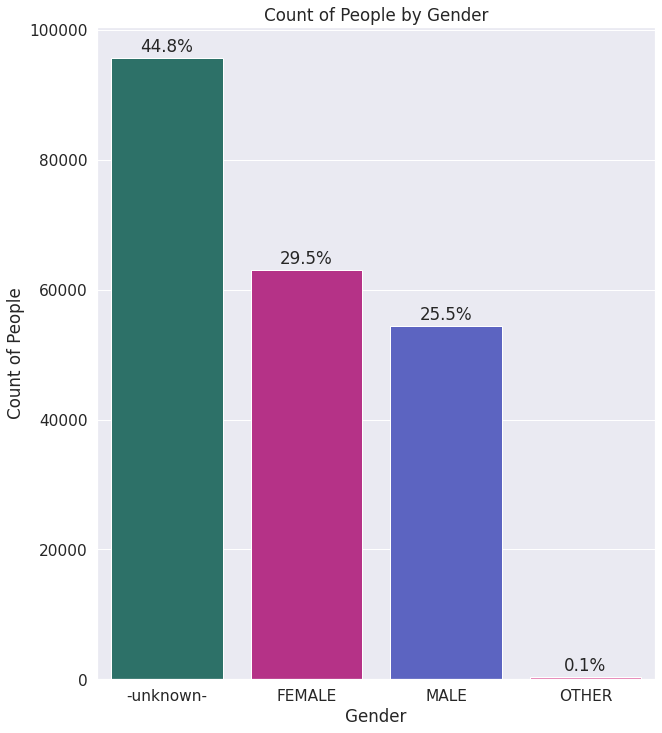

In [240]:
sns.set(font_scale=1.4)

plt.figure(figsize=(10,12))

count1 = train['gender'].value_counts().index

sns.countplot(data=train, x = 'gender',order=count1 , palette=['#227C70',"#CB1C8D", '#4B56D2', '#F56EB3'])
plt.xlabel("Gender")
plt.ylabel("Count of People")
plt.title("Count of People by Gender")

count2 = train['gender'].value_counts()

for i in range(count2.shape[0]):
    count = count2[i]
    a='{:0.1f}%'.format(100*count / train.shape[0])
    plt.text(i,count+1000,a,ha='center')


We can see that the -unknown- gender is the most dominant one. -unknown- means that the gender is missing for that user, so we have to convert it to nan values. 

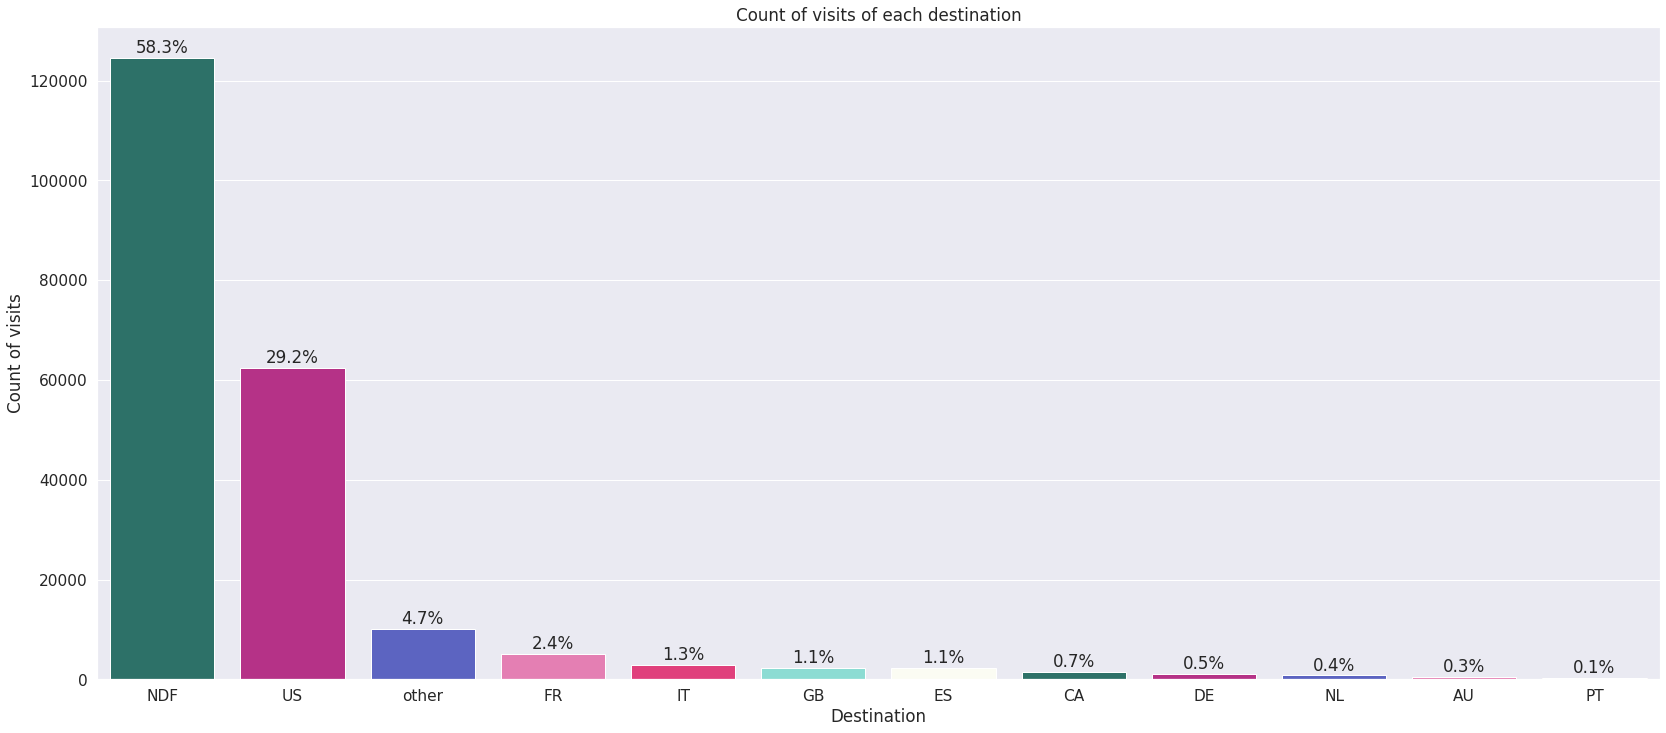

In [241]:
sns.set(font_scale=1.4)

plt.figure(figsize=(28,12))

count1 = train['country_destination'].value_counts().index

sns.countplot(data=train, x = 'country_destination',order=count1 , palette=['#227C70',"#CB1C8D", '#4B56D2', '#F56EB3', '#FB2576', '#7FE9DE' , '#FCFDF2'])
plt.xlabel("Destination")
plt.ylabel("Count of visits")
plt.title("Count of visits of each destination")

count2 = train['country_destination'].value_counts()

for i in range(count2.shape[0]):
    count = count2[i]
    a='{:0.1f}%'.format(100*count / train.shape[0])
    plt.text(i,count+1000,a,ha='center')


NDF means that the person has never booked after creating an account. The NDF value is not really important and doesn't give us clear insights about the new destination of airbnb costumers=> it won't help us in our predictions, so we are going to drop all the rows containing NDF.

In [242]:
train = train[train.country_destination != 'NDF']


In [243]:
train.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,first_device_type,country_destination,tfa_year,tfa_month,tfa_day
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,en,direct,direct,untracked,Windows Desktop,US,2009,6,Tuesday
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,en,direct,direct,untracked,Mac Desktop,other,2009,10,Saturday
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.0,basic,en,direct,direct,untracked,Mac Desktop,US,2009,12,Tuesday
5,osr2jwljor,2010-01-01,2010-01-01 21:56:19,-unknown-,34.0,basic,en,other,other,omg,Mac Desktop,US,2010,1,Friday
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,FEMALE,46.0,basic,en,other,craigslist,untracked,Mac Desktop,US,2010,1,Saturday


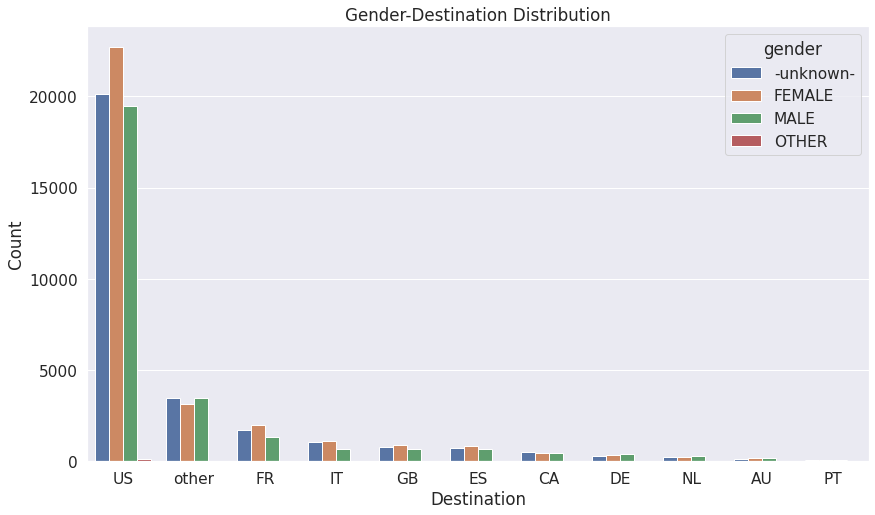

In [244]:
#Gender-Destination Distribution Plot

plt.figure(figsize=(14,8))
order1 = train['country_destination'].value_counts().index
sns.countplot(data = train, x = 'country_destination', order = order1,hue='gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Gender-Destination Distribution')
order2 = train['country_destination'].value_counts()

According to the plot above, there's no big difference in the number of reservations between women and men, so this plot doesn't give us clear insights

**Sign-up methods used by users**

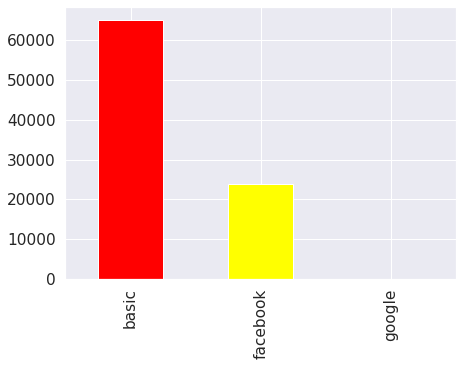

In [245]:
plt.figure(figsize=(7,5))

train.signup_method.value_counts(dropna=False).plot(kind='bar', color=['red', 'yellow','pink', 'green'])

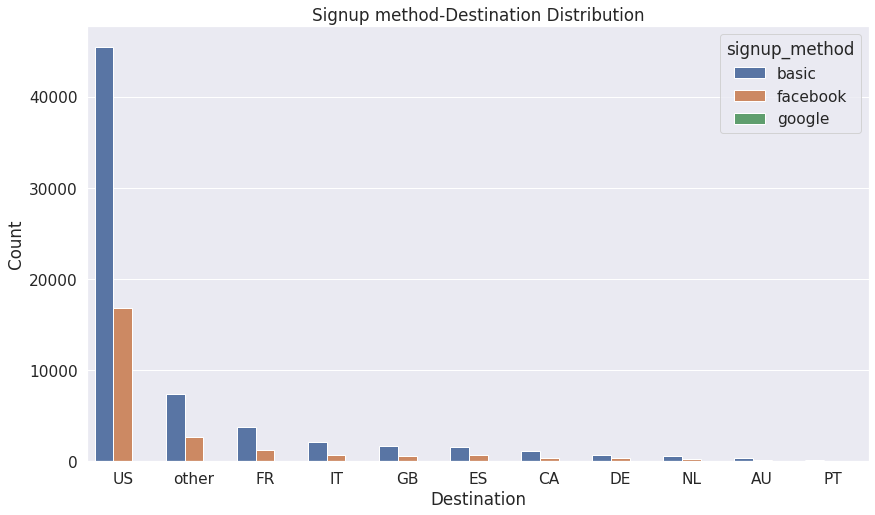

In [246]:

plt.figure(figsize=(14,8))
order1 = train['country_destination'].value_counts().index
sns.countplot(data = train, x = 'country_destination', order = order1,hue='signup_method')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Signup method-Destination Distribution')
order2 = train['country_destination'].value_counts()

**Users Devices**

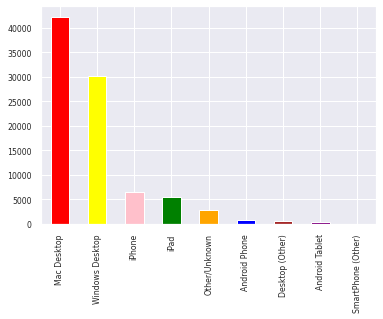

In [247]:
sns.set(font_scale=0.7)

train.first_device_type.value_counts(dropna=False).plot(kind='bar', color=['red', 'yellow','pink', 'green', 'orange','blue','brown','purple','black'])

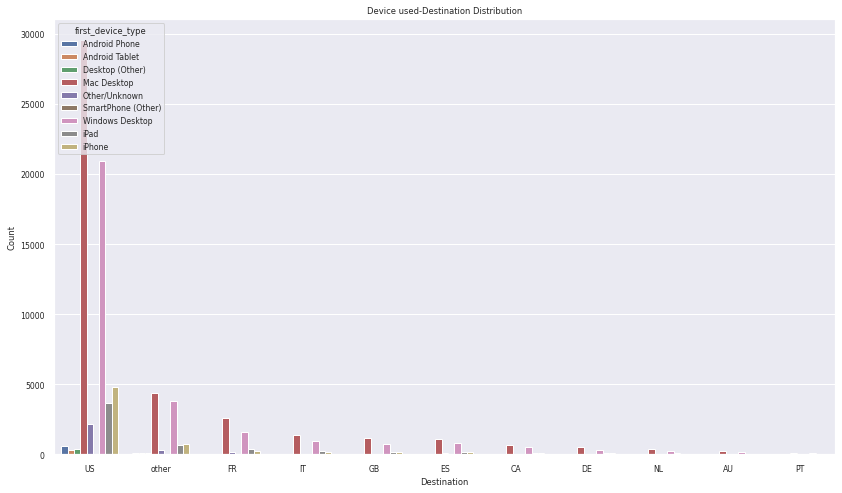

In [248]:

plt.figure(figsize=(14,8))
order1 = train['country_destination'].value_counts().index
sns.countplot(data = train, x = 'country_destination', order = order1,hue='first_device_type')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Device used-Destination Distribution')
order2 = train['country_destination'].value_counts()

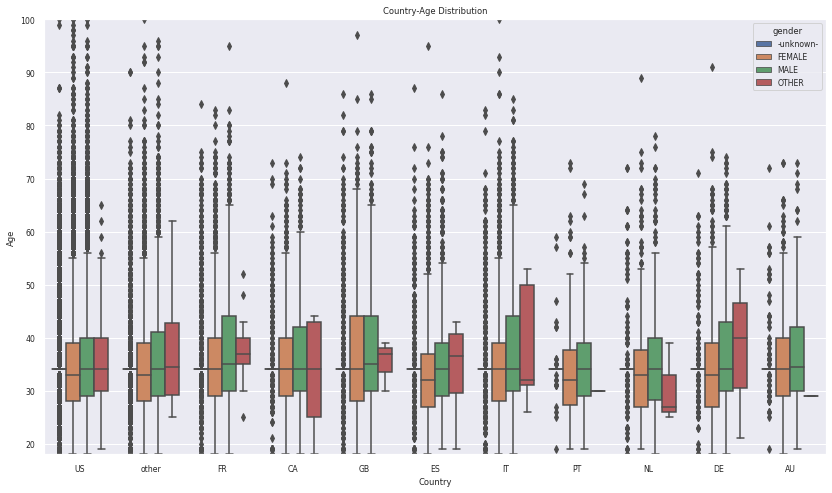

In [249]:
#Relationship between age-gender-destination

plt.figure(figsize=[14,8])
sns.boxplot(data=train,y='age',x='country_destination',hue='gender');
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution');

**DATES**

In [250]:
# Date_account_created transformation
# Separate the day month and year into different columns
dac = np.vstack(train.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
print(dac)
train['dac_year'] = dac[:,0]
train['dac_mounth'] = dac[:,1]
train['dac_day'] = dac[:,2]

train['date_account_created']=pd.to_datetime(train['date_account_created'])
from datetime import datetime
l=[]
for i in train['date_account_created']:
  l.append(i.strftime('%A'))

train['dac_day']=l
train = train.drop(['date_account_created'], axis = 1)





[[2010    9   28]
 [2011   12    5]
 [2010    9   14]
 ...
 [2014    6   30]
 [2014    6   30]
 [2014    6   30]]


To see the dates and the timespans of our users, let's plot the number of accounts created by time:



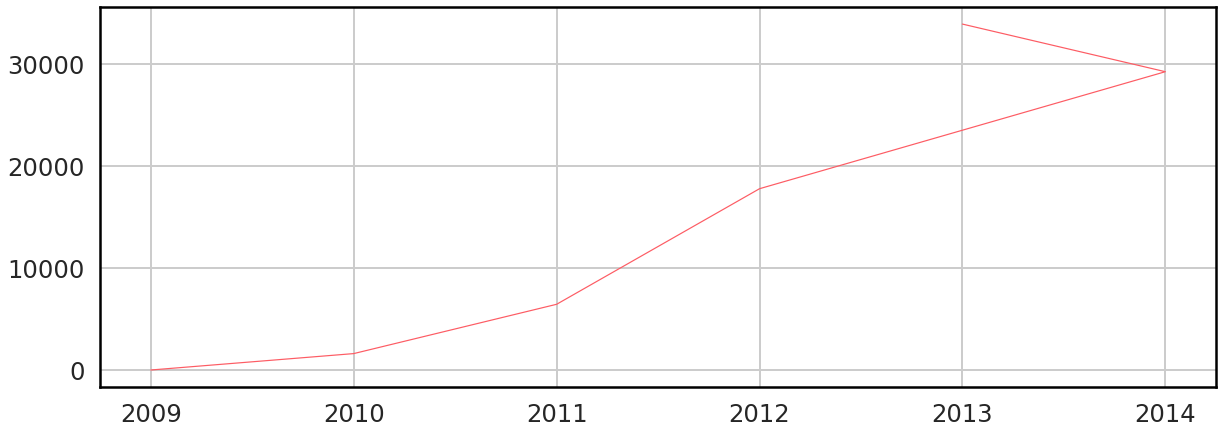

In [251]:
plt.figure(figsize=(20,7))
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
train.tfa_year.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

 Airbnb has grown soo fast over the last 2 years. 


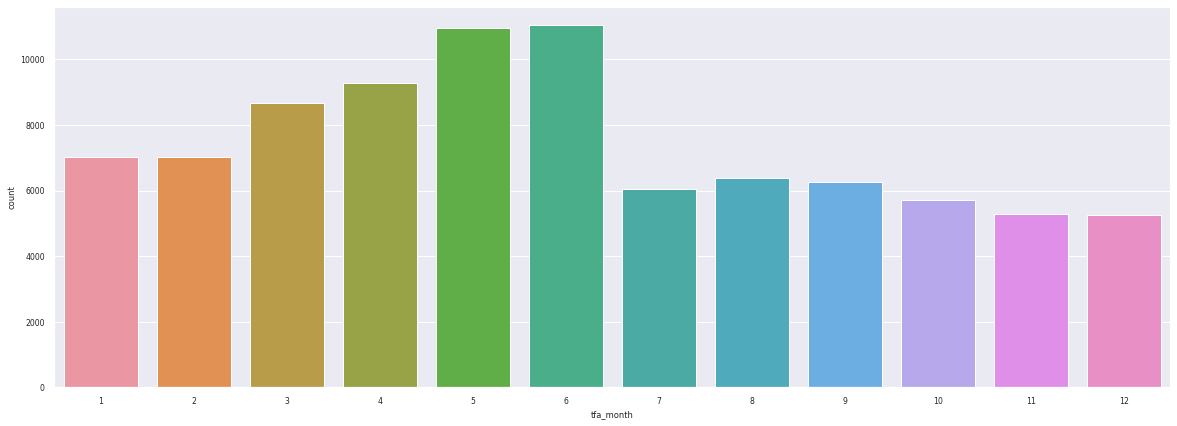

In [252]:
plt.figure(figsize=(20,7))
sns.set(font_scale=0.7)
sns.countplot(x ='tfa_month', data = train)
 
plt.show()



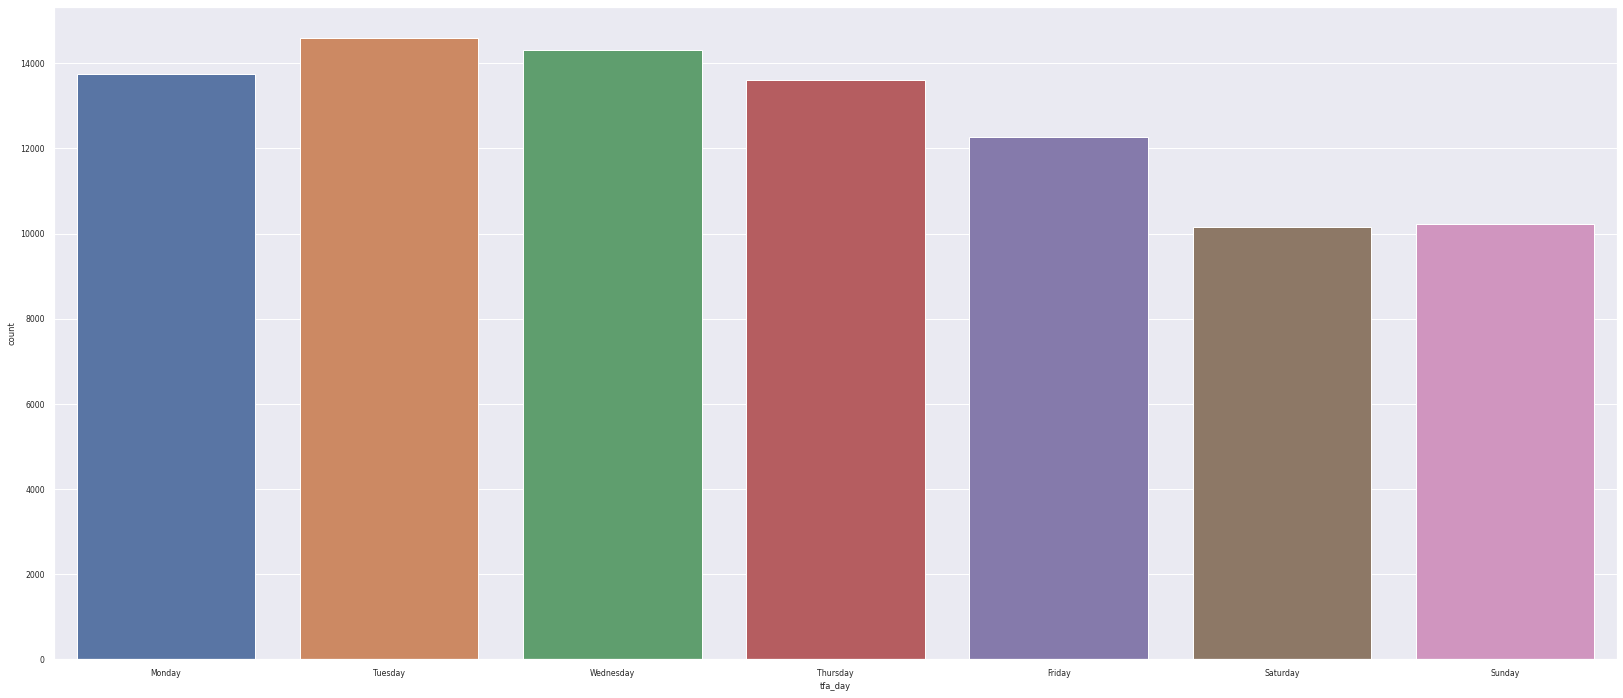

In [253]:
plt.figure(figsize=(28,12))


sns.countplot(x ='tfa_day', data = train, order=["Monday","Tuesday","Wednesday","Thursday", 'Friday', 'Saturday', 'Sunday'])
 
plt.show()

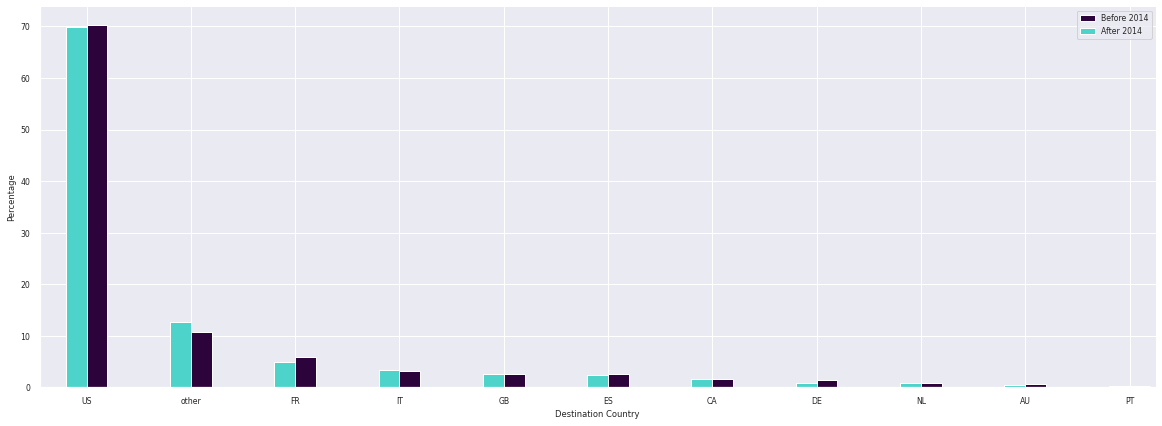

In [254]:
date = pd.to_datetime(20140101, format='%Y%m%d')

plt.figure(figsize=(20,7))

before = sum(train.loc[train['timestamp_first_active'] < date, 'country_destination'].value_counts())
after = sum(train.loc[train['timestamp_first_active'] > date, 'country_destination'].value_counts())
before_destinations = train.loc[train['timestamp_first_active'] < date, 
                                'country_destination'].value_counts() / before * 100
after_destinations = train.loc[train['timestamp_first_active'] > date, 
                               'country_destination'].value_counts() / after * 100
before_destinations.plot(kind='bar', width=0.2, color='#2D033B', position=0, label='Before 2014', rot=0)
after_destinations.plot(kind='bar', width=0.2, color='#4DD3C9', position=1, label='After 2014', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

It's a  comparision of usual destinations then and now (2014), where we can see how the new users, register more and book less, and when they book they stay at the US.

In [255]:
train.head()

,id,timestamp_first_active,gender,age,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,first_device_type,country_destination,tfa_year,tfa_month,tfa_day,dac_year,dac_mounth,dac_day
2,4ft3gnwmtx,2009-06-09 23:12:47,FEMALE,56.0,basic,en,direct,direct,untracked,Windows Desktop,US,2009,6,Tuesday,2010,9,Tuesday
3,bjjt8pjhuk,2009-10-31 06:01:29,FEMALE,42.0,facebook,en,direct,direct,untracked,Mac Desktop,other,2009,10,Saturday,2011,12,Monday
4,87mebub9p4,2009-12-08 06:11:05,-unknown-,41.0,basic,en,direct,direct,untracked,Mac Desktop,US,2009,12,Tuesday,2010,9,Tuesday
5,osr2jwljor,2010-01-01 21:56:19,-unknown-,34.0,basic,en,other,other,omg,Mac Desktop,US,2010,1,Friday,2010,1,Friday
6,lsw9q7uk0j,2010-01-02 01:25:58,FEMALE,46.0,basic,en,other,craigslist,untracked,Mac Desktop,US,2010,1,Saturday,2010,1,Saturday


In [256]:
print(train.isna().sum())
print('---------------------------------------------------')
print(test.isna().sum())


id                            0
timestamp_first_active        0
gender                        0
age                           0
signup_method                 0
language                      0
affiliate_channel             0
affiliate_provider            0
first_affiliate_tracked    1738
first_device_type             0
country_destination           0
tfa_year                      0
tfa_month                     0
tfa_day                       0
dac_year                      0
dac_mounth                    0
dac_day                       0
dtype: int64
---------------------------------------------------
id                          0
date_account_created        0
timestamp_first_active      0
gender                      0
age                         0
signup_method               0
language                    0
affiliate_channel           0
affiliate_provider          0
first_affiliate_tracked    20
first_device_type           0
dtype: int64


In [257]:
train = train.drop(['timestamp_first_active'], axis=1)


In [258]:
train['first_affiliate_tracked'] = train['first_affiliate_tracked'].fillna(train['first_affiliate_tracked'].mode()[0])
test['first_affiliate_tracked'] = test['first_affiliate_tracked'].fillna(test['first_affiliate_tracked'].mode()[0])



In [259]:
# Date_account_created transformation
# Separate the day month and year into different columns
dac = np.vstack(test.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
print(dac)
test['dac_year'] = dac[:,0]
test['dac_mounth'] = dac[:,1]
test['dac_day'] = dac[:,2]

test['date_account_created']=pd.to_datetime(test['date_account_created'])
from datetime import datetime
l=[]
for i in test['date_account_created']:
  l.append(i.strftime('%A'))

test['dac_day']=l
test = test.drop(['date_account_created'], axis = 1)

[[2014    7    1]
 [2014    7    1]
 [2014    7    1]
 ...
 [2014    9   30]
 [2014    9   30]
 [2014    9   30]]


In [260]:
# timestamp_first_active transformation
# Here as well we separate the timestamp first active into day mount and year
tfa = np.vstack(test.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
print(tfa)
test['tfa_year'] = tfa[:,0]
test['tfa_month'] = tfa[:,1]
test['tfa_day'] = tfa[:,2]


test['timestamp_first_active']=pd.to_datetime(test['timestamp_first_active'],format='%Y%m%d%H%M%S')
from datetime import datetime
k=[]
for i in test['timestamp_first_active']:
  k.append(i.strftime('%A'))

test['tfa_day']=k
test = test.drop(['timestamp_first_active'], axis = 1)

[[2014    7    1    0    0    6]
 [2014    7    1    0    0   51]
 [2014    7    1    0    1   48]
 ...
 [2014    9   30   23   54    8]
 [2014    9   30   23   54   30]
 [2014    9   30   23   59    1]]


In [261]:
print(train.info())
print('---------------------------------------------------')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88908 entries, 2 to 213445
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       88908 non-null  object  
 1   gender                   88908 non-null  category
 2   age                      88908 non-null  float64 
 3   signup_method            88908 non-null  category
 4   language                 88908 non-null  category
 5   affiliate_channel        88908 non-null  category
 6   affiliate_provider       88908 non-null  category
 7   first_affiliate_tracked  88908 non-null  category
 8   first_device_type        88908 non-null  category
 9   country_destination      88908 non-null  object  
 10  tfa_year                 88908 non-null  int64   
 11  tfa_month                88908 non-null  int64   
 12  tfa_day                  88908 non-null  object  
 13  dac_year                 88908 non-null  int64   
 14  dac_m

In [262]:
categorical_features=['dac_day', 'tfa_day','id']

for i in categorical_features:
    train[i] = train[i].astype('category')

for i in categorical_features:
    test[i] = test[i].astype('category')


train['age'] = train['age'].astype(np.int64)

In [263]:
print(train['gender'].value_counts())
print('------------------------------')
print(test['gender'].value_counts())




FEMALE       31993
-unknown-    29018
MALE         27721
OTHER          176
Name: gender, dtype: int64
------------------------------
-unknown-    33792
FEMALE       14483
MALE         13769
OTHER           52
Name: gender, dtype: int64


In [264]:
train['gender']=train['gender'].replace('-unknown-' , np.nan)
test['gender']=test['gender'].replace('-unknown-' , np.nan)


In [265]:
print('Number of missing values in the train data: ', train.gender.isna().sum())
print('---------------------------------------------------')
print('Number of missing values in the train data: ', test.gender.isna().sum())


Number of missing values in the train data:  29018
---------------------------------------------------
Number of missing values in the train data:  33792


In [266]:
train=train.dropna(subset=['gender'])
test=test.dropna(subset=['gender'])



In [267]:
#one hot encoding
columns = ['gender', 'signup_method', 
           #'signup_flow',
           'language', 'affiliate_channel',
             'affiliate_provider', 'first_affiliate_tracked', 
           #'signup_app', 
           'first_device_type',
           #'first_browser',
           'tfa_day', 'dac_day']
for column in columns:
    train_dummies = pd.get_dummies(train[column], prefix=column)
    train = train.drop([column], axis=1)
    train = pd.concat((train, train_dummies), axis=1)

for column in columns:
    test_dummies = pd.get_dummies(test[column], prefix=column)
    test = test.drop([column], axis=1)
    test = pd.concat((test, test_dummies), axis=1)

